In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate

The goal of this notebook is to build a routine that takes in an equation of state (or several) and produces mass/radius curves from the Tolmann-Oppenheiner-Volkov (TOV) equations. We begin with a brief introduction of the TOV equations. The TOV equations are two equations relating the energy density ($\epsilon$), pressure ($P$), and mass ($m$) of a neutron star. The first equation, shown below, is derived by solving the Einstein equations for a time-invariant, spherically symmetric metric

$$ \frac{dP}{dr} = - \frac{GM}{r^2} \epsilon \left( 1 + \frac{P}{\epsilon c^2} \right) \left( 1 + \frac{4\pi r^3 P}{Mc^2} \right) \left( 1 - \frac{2GM}{rc^2} \right)^{-1} $$

where $r$ is the radial coordinate and $G$ is the gravitational constant. The second equation is essentially conservation of energy/mass

$$ \frac{dM}{dr} = 4 \pi r^2 \rho $$

The energy density is related to the mass density by

$$ \epsilon = \rho + \frac{E}{N} n = \left( m_{N} + \frac{E}{N} \right)n $$

where $n$ is the baryon density, $m_{N}$ is the neutron mass, and $E/N$ is the energy per particle. We will be using the polytropic equation of state (EOS) given by

$$ P(\rho) = K \rho^\Gamma $$

where $\Gamma$ is a dimensionless constant, and $K$ is a constant of proportionality. The first thing we do is, from an EOS, construct a three column array containing $\epsilon$, $\rho$, and $P$. We will also find it necessary to have the energy density as a function of the pressure. The mass density term is straightforward, but by using a thermodynamic relation

$$ P = n^2 \frac{\partial (E / N)}{\partial n} = \frac{\rho^2}{m_{N}}\frac{\partial (E / N)}{\partial \rho} \quad \implies \quad \frac{E}{N} = m_{N} \int \frac{P}{\rho^2} d\rho = \frac{Km_{N}\rho^{\Gamma-1}}{\Gamma -1} + C $$

where $C$ is the constant of integration. This constant is actually just the energy associated with the rest mass (aka the other term in our original expression). Thus we can say

$$ \epsilon(P) = \left( \frac{P}{K} \right)^{1/\Gamma} + \frac{P}{\Gamma-1} $$

In [4]:
def polytropic_EOS(K, Gamma, a_c, size):
    """
    This function will take in parameters for the polytropic equation of state (K and Gamma) as well as a size and
    output a table with three columns of length n.
    
    input:
    K: scalar parameter for EOS, units are determined by Gamma to make EOS have correct dimensions.
    Gamma: unitless scalar parameter for EOS, must be greater than 1.
    a_c: unitless scalar, factor multiplied by saturation density, determines highest density in table.
    size: unitless scalar, determines length of each column.
    
    output:
    table: 3xsize numpy array containing mass density(km^-2), pressure(km^-2), and energy density(km^-2)
    in units where c=G=1.
    """
    
    rho_s = 2e-4 #km^-2
    p_c = K*(a_c*rho_s)**Gamma
    
    #first we create a grid of mass density
    
    rho_c = a_c*rho_s
    rho = np.linspace(0, rho_c, size)
    p = K*(rho**Gamma)
    epsilon = rho + p/(Gamma-1)
    
    table = np.vstack((rho, p, epsilon))
    
    return table, p_c

Now that we have our table of inputs, let's simplify the differential equation we're working with. By introducing the variable $y = r^2$ the first TOV equation turns into

$$ \frac{dy}{dP} = - \frac{2yc^2}{G} \frac{\sqrt{y} - 2GM/c^2}{(c^2 \epsilon + P)(M + 4\pi y^{3/2} P/c^2)} $$

Note that we can make this switch because $r$ is the radial coordinate and only takes positive values. It will be convenient to work in units where $c = G = 1$ and we can do this by defining:

$$ \overline{P} = \frac{G}{c^4}P \quad \overline{\epsilon} = \frac{G}{c^2}\epsilon \quad \overline{\rho} = \frac{G}{c^2} \rho $$

Next we rewrite this in terms of our $\bar{P}$, $\bar{\rho}$, and $\bar{\epsilon}$ variables.

$$ \frac{dy}{d\bar{P}} = \frac{-2y\left(\sqrt{y} - 2\bar{M}\right) }{\left(\bar{\epsilon} + \bar{P}\right)\left(\bar{M} + 4\pi y^{3/2} \bar{P}\right)} $$

After this we can transform the total mass equation in the same way

$$ \frac{d\bar{M}}{dr} = 4\pi r^2 \bar{\rho} = 4 \pi y \frac{G}{c^2} \left( \frac{P}{K} \right)^{1/\Gamma} $$

Please ignore the terrible notation. Now using the chain rule we get

$$ \frac{d\bar{M}}{d\bar{P}} = \frac{d\bar{M}}{dr} \frac{dr}{d\bar{P}} \quad \implies \quad \frac{d\bar{M}}{d\bar{P}} = \frac{ 4\pi \bar{\epsilon} y^{3/2} \left( \sqrt{y} - 2\bar{M} \right) }{\left( \bar{\epsilon} + \bar{P} \right) \left( \bar{M} + 4\pi \bar{P} y^{3/2} \right)} $$

Thus we have the two necessary equations to solve for $y$ and $\bar{M}$. We label the two equations and define a vector, $V$ as:

$$ \begin{bmatrix} \frac{dy}{d\bar{P}}\\ \frac{d\bar{M}}{d\bar{P}} \end{bmatrix} = \begin{bmatrix} f \\ g \end{bmatrix} \quad ; \quad V = \begin{bmatrix} y \\ \bar{M} \end{bmatrix} \quad \implies \quad \frac{dV}{d\bar{P}} = \begin{bmatrix} f \\ g \end{bmatrix}$$

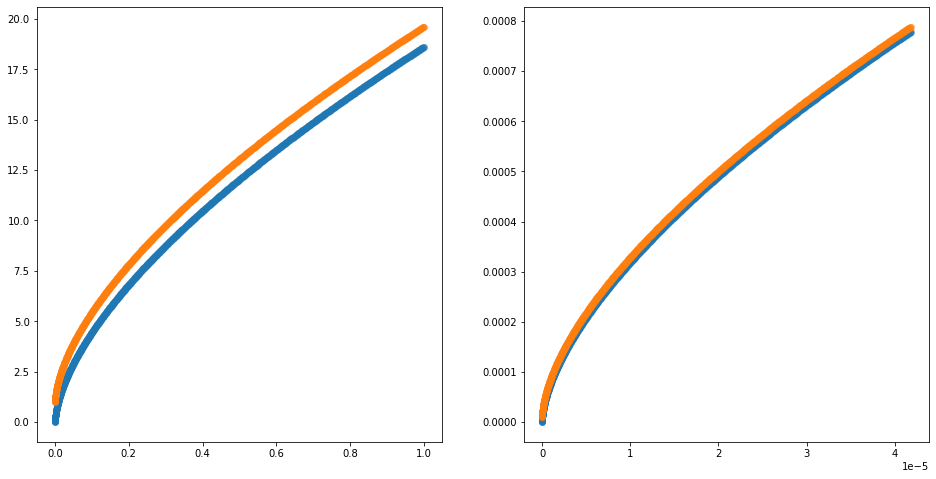

In [5]:
Gamma = 5/3
K = 7.3
a_c = 3.58
size = int(1e3)

EOS_table, p_c = polytropic_EOS(K, Gamma, a_c, size)

# grabbing relevant quantities
p_bar = EOS_table[1,:].reshape(size,)
e_bar = EOS_table[2,:].reshape(size,)

# nondimensionalized (incorrectly?)
p_til = EOS_table[1,:].reshape(size,)/p_c
e_til = EOS_table[2,:].reshape(size,)/p_c

# interpolates the table to get a function for the energy density
e_bar_func = scipy.interpolate.CubicSpline(p_bar, e_bar)
e_til_func = scipy.interpolate.CubicSpline(p_til, e_til)

# plot our interpolations over the table
fig, ax = plt.subplots(1,2, figsize= (16,8))

ax[0].plot(p_til,e_til, 'o', alpha=0.5)
ax[0].plot(p_til, e_til_func(p_til)+1, 'o', alpha=0.5)

ax[1].plot(p_bar,e_bar, 'o', alpha=0.5)
ax[1].plot(p_bar, e_bar_func(p_bar)+1e-5, 'o', alpha=0.5)

In [6]:
def func_dV(p_bar,V):
    """
    Function that characterizes the ODE we are solving.
    
    Inputs:
    p_bar: scalar input for pressure
    V: vector of (y, M_bar), np.array of shape(2,k)
    
    Outputs:
    dV = vector (f,g) defined above, np.array of shape (2,k) 
    """
    dV = np.zeros(V.shape)
    
    num0 = -2*V[0,:]*(np.sqrt(V[0,:])-2*V[1,:])
    den0 = (e_bar_func(p_bar)+p_bar)*(V[1,:]+4*np.pi*p_bar*V[0,:])
    
    dV[0,:] = num0/den0
    
    num1 = -4*np.pi*e_bar_func(p_bar)*(V[0,:]**(3/2))*(np.sqrt(V[0,:])-2*V[1,:])
    den1 = (e_bar_func(p_bar)+p_bar)*(V[1,:]+4*np.pi*p_bar*V[0,:])
    
    dV[1,:] = num1/den1
    
    return dV

In [14]:
t0 = p_c
y0 = np.array([1e-5,1e-5])
t_bound = 1e-10*p_c

steps = 100
solution = np.zeros((2,steps))
pressure = np.zeros(steps)
max_step = 1/steps

i=0

TOV_solution = scipy.integrate.RK45(func_dV, t0, y0, t_bound, max_step=max_step, vectorized=True)

while i<steps and TOV_solution.t > 1e-12:

    solution[:,i] = TOV_solution.y
    pressure[i] = TOV_solution.t
    TOV_solution.step()
    i +=1

C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in power
C:\Users\brend\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in sqrt


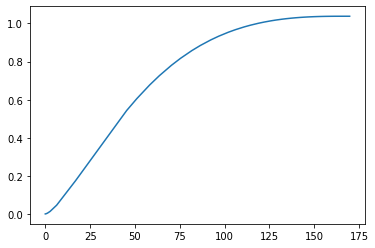

In [15]:
for i in range(steps):
    if solution[0,i] == 0:
        solution[0,i] = max(solution[0,:])
    if solution[1,i] == 0:
        solution[1,i] = max(solution[1,:])

plt.plot(solution[0,:], solution[1,:])

In [16]:
radius_km = np.sqrt( solution[0,:] )
mass_Mo = solution[1,:]/1.4766

max_radius = np.max(radius_km)
max_mass = np.max(mass_Mo)

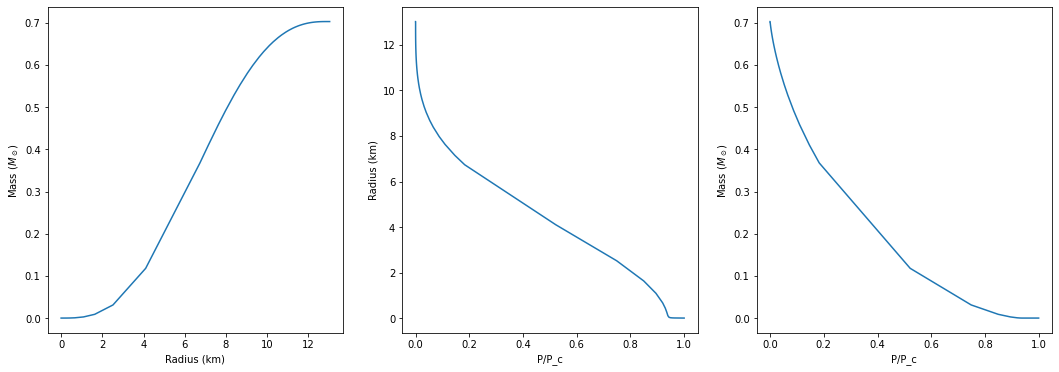

In [17]:
fig, ax = plt.subplots(1,3, figsize = (18,6))

ax[0].plot(radius_km, mass_Mo)
ax[0].set_xlabel('Radius (km)')
ax[0].set_ylabel('Mass ($M_\odot$)')

ax[1].plot(pressure/p_c, radius_km)
ax[1].set_xlabel('P/P_c')
ax[1].set_ylabel('Radius (km)')

ax[2].plot(pressure/p_c, mass_Mo)
ax[2].set_xlabel('P/P_c')
ax[2].set_ylabel('Mass ($M_\odot$)')

# plt.savefig('MR_RP_MP.png')

In [18]:
print(max_mass, max_radius)

0.7030196481698382 13.027647563199045


In [ ]:
maxes

solver_params = 